In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')


In [ ]:
!pip install unsloth vllm trl==0.18.1 accelerate==1.7.0

In [1]:
import torch
import unsloth
torch.cuda.is_available()

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 06-20 11:17:58 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 06-20 11:17:59 [__init__.py:239] Automatically detected platform cuda.


True

In [2]:
import torch
from trl import SFTTrainer
from transformers import TrainingArguments, TextStreamer
from unsloth.chat_templates import get_chat_template
from unsloth import FastLanguageModel
from datasets import Dataset
from unsloth import is_bfloat16_supported

# Saving model
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


In [10]:
import pandas as pd

# Login using e.g. `huggingface-cli login` to access this dataset
df = pd.read_parquet("hf://datasets/AlicanKiraz0/Cybersecurity-Dataset-v1/cybersecurity-dataset-train-data.parquet")

In [11]:
df.head()

,system,user,assistant
0,You are a highly specialized AI assistant for ...,Explain the fundamental data flow of a Reflect...,Reflected XSS attacks occur when an attacker s...
1,You are a highly specialized AI assistant for ...,How does a Reflected XSS vulnerability in an A...,The difference between reflected cross-site sc...
2,You are a highly specialized AI assistant for ...,"What is \""DOM Clobbering\"" and how can it be u...",DOM Clobbering occurs when an object property ...
3,You are a highly specialized AI assistant for ...,"Explain the concept of \""filter evasion\"" in t...",XSS attacks are the most dangerous vulnerabili...
4,You are a highly specialized AI assistant for ...,"How can character encoding (e.g., UTF-7, UTF-1...",This is the first time I will be teaching a cl...


## EDA

<Figure size 1000x300 with 0 Axes>

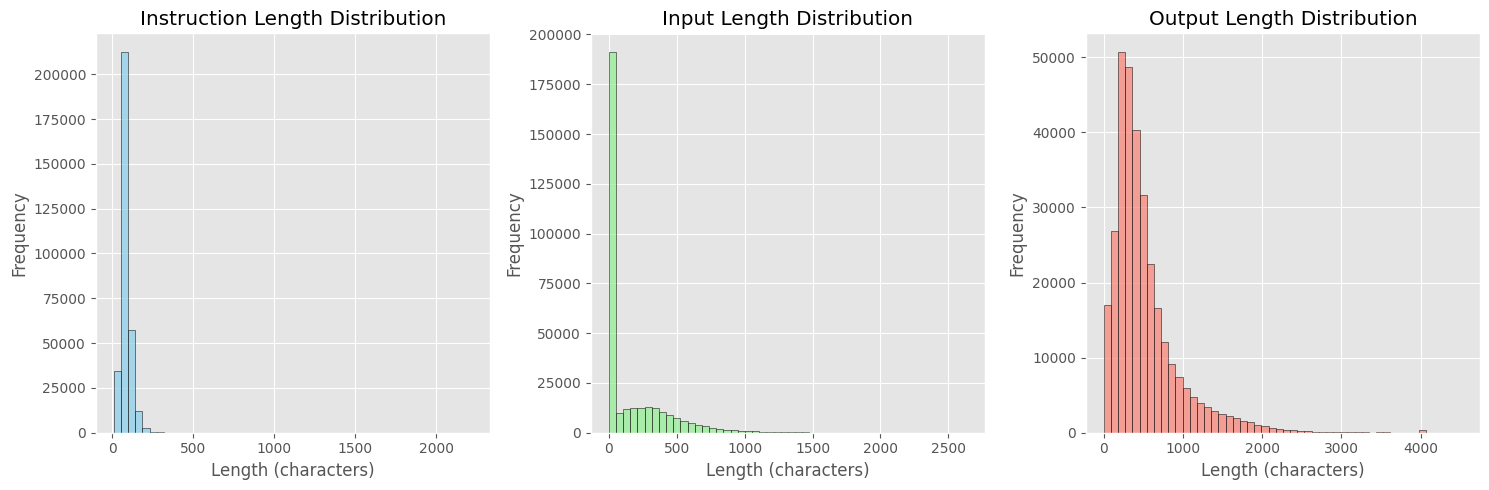

Summary Statistics:
Instruction - Mean: 76.0, Median: 56.0, Max: 2220
Input - Mean: 156.6, Median: 0.0, Max: 2638
Output - Mean: 521.8, Median: 397.0, Max: 4522


In [22]:
# Visualization of length of instruction, input, and output column 

plt.figure(figsize=(10, 3))
# Create subplots for each column
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot instruction length distribution
instruction_lengths = df['instruction'].str.len()
axes[0].hist(instruction_lengths, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('Instruction Length Distribution')
axes[0].set_xlabel('Length (characters)')
axes[0].set_ylabel('Frequency')

# Plot input length distribution
input_lengths = df['input'].str.len()
axes[1].hist(input_lengths, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1].set_title('Input Length Distribution')
axes[1].set_xlabel('Length (characters)')
axes[1].set_ylabel('Frequency')

# Plot output length distribution
output_lengths = df['output'].str.len()
axes[2].hist(output_lengths, bins=50, alpha=0.7, color='salmon', edgecolor='black')
axes[2].set_title('Output Length Distribution')
axes[2].set_xlabel('Length (characters)')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary Statistics:")
print(f"Instruction - Mean: {instruction_lengths.mean():.1f}, Median: {instruction_lengths.median():.1f}, Max: {instruction_lengths.max()}")
print(f"Input - Mean: {input_lengths.mean():.1f}, Median: {input_lengths.median():.1f}, Max: {input_lengths.max()}")
print(f"Output - Mean: {output_lengths.mean():.1f}, Median: {output_lengths.median():.1f}, Max: {output_lengths.max()}")


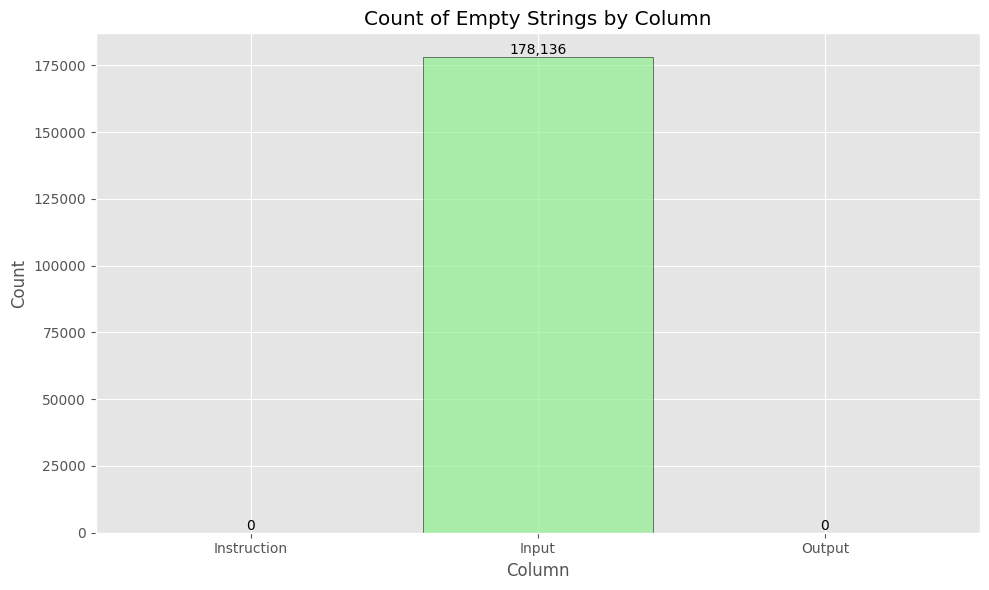

Empty strings found:
Instruction column: 0 (0.00%)
Input column: 178,136 (55.78%)
Output column: 0 (0.00%)


In [23]:
# Visualization of empty string in instruction, input, and output column

# Count empty strings in each column
empty_instruction = (df['instruction'] == '').sum()
empty_input = (df['input'] == '').sum()
empty_output = (df['output'] == '').sum()

# Create bar plot for empty string counts
fig, ax = plt.subplots(figsize=(10, 6))
columns = ['Instruction', 'Input', 'Output']
empty_counts = [empty_instruction, empty_input, empty_output]
colors = ['skyblue', 'lightgreen', 'salmon']

bars = ax.bar(columns, empty_counts, color=colors, alpha=0.7, edgecolor='black')
ax.set_title('Count of Empty Strings by Column')
ax.set_ylabel('Count')
ax.set_xlabel('Column')

# Add value labels on top of bars
for bar, count in zip(bars, empty_counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{count:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary
print(f"Empty strings found:")
print(f"Instruction column: {empty_instruction:,} ({empty_instruction/len(df)*100:.2f}%)")
print(f"Input column: {empty_input:,} ({empty_input/len(df)*100:.2f}%)")
print(f"Output column: {empty_output:,} ({empty_output/len(df)*100:.2f}%)")


In [24]:
# Show input column which value is not empty string

df[df['input'] != ''].head(5)

,instruction,input,output
28738,Conduct a thorough risk assessment for a new e...,We are about to launch a new e-commerce platfo...,"After conducting the risk assessment, I've ide..."
28739,Perform a TTP mapping for a recent cyber attac...,Our system was recently attacked and we suspec...,"Based on the analysis of the attack, I've iden..."
28740,Evaluate the effectiveness of a newly implemen...,We recently implemented a new data loss preven...,"After evaluating the DLP solution, I found tha..."
28741,Investigate and determine the root cause of a ...,We have observed a suspicious activity in one ...,"After investigating, I've determined that the ..."
28742,Conduct a penetration test on a web applicatio...,We have a new web application that handles sen...,"After conducting the penetration test, I've id..."


In [25]:
# Show input column which value is empty string

df[df['input'] == ''].head(5)

,instruction,input,output
0,What is a critical security consideration when...,,A critical aspect of wireless security is usin...
1,"In a secure network design, how does the imple...",,VLANs enhance network security by logically se...
2,In a scenario where an attacker intercepts and...,,A Man-in-the-Middle attack involves an attacke...
3,"In the context of cryptographic concepts, what...",,Digital signatures are used to verify the auth...
4,What is a key consideration when implementing ...,,"When implementing secure mobile solutions, it'..."


In [4]:
# I noticed, started from page 1600, the data is not relevant to cybersec
# I will remove the data from page 1600 to the end

df.iloc[:160000]

# For better training, I will remove the data from page 1600 to the end and sample 50000 from the first 150000


df_sampled = df.iloc[:150000].sample(n=50000)


In [54]:
# print the first 5 rows of the dataframe completely 
pd.options.display.max_colwidth = None
df_sampled[df_sampled['input'] == ''].head(5)

,instruction,input,output
12564,What is the base score of CVE-2023-21058 and how severe is it?,,"The base score of CVE-2023-21058 is 9.8, and it is rated as CRITICAL in terms of severity."
46901,Please provide detailed information about CVE-2021-20228,,"CVE:CVE-2021-20228\nDescription:A flaw was found in the Ansible Engine 2.9.18, where sensitive info is not masked by default and is not protected by the no_log feature when using the sub-option feature of the basic.py module. This flaw allows an attacker to obtain sensitive information. The highest threat from this vulnerability is to confidentiality.\npublished:2021-04-29T16:15:09.737"
24016,What might be a possible attack scenario for CVE-2023-0192?,,"A possible attack scenario for CVE-2023-0192 could involve an attacker with local access to a system exploiting the vulnerability to elevate their privileges. After gaining the necessary privileges, the attacker could manipulate the system, access protected information, or install malicious software that could be used to compromise the system further."
129265,Please provide detailed information about CVE-2024-26819,,CVE:CVE-2024-26819\nDescription:Rejected reason: This CVE ID has been rejected or withdrawn by its CVE Numbering Authority.\npublished:2024-04-17T10:15:08.810
127853,Please provide detailed information about CVE-2024-31308,,CVE:CVE-2024-31308\nDescription:Deserialization of Untrusted Data vulnerability in VJInfotech WP Import Export Lite.This issue affects WP Import Export Lite: from n/a through 3.9.26.\npublished:2024-04-07T18:15:12.253


In [55]:
df_sampled[df_sampled['input'] != ''].head(5)

,instruction,input,output
38239,"Security Information and Event Management (SIEM) Alert Investigation, analyzing the SIEM alerts generated by monitoring events on the network, and determining the steps necessary for investigation and response.",Our SIEM system is generating an alert for an unauthorized attempt to access our internal network. Can you investigate and provide recommendations on how to respond?,The alert is being generated by a firewall blocking an external IP address that was attempting to make multiple unauthorized login attempts on an internal server. We recommend investigating the external IP address to determine the source of the attack and taking appropriate measures to block it from accessing the network.
39776,"Compliance, Ensuring compliance with industry-specific regulations.",Assess the organization's compliance with the General Data Protection Regulation (GDPR).,"The organization has implemented several measures to comply with GDPR, including obtaining consent for data collection and processing, implementing data protection measures, and providing individuals with the right to access and control their data. Further improvements are necessary to comply with GDPR fully, such as appointing a data protection officer and conducting regular privacy impact assessments."
31006,"Create a response plan for a ransomware attack on a corporate network, including steps for containment, recovery, and prevention.","A ransomware attack has occurred on a corporate network, infecting multiple systems and encrypting sensitive data. The attackers are demanding a ransom payment in exchange for the decryption key.","The response plan for the ransomware attack should include the following steps:\n1. Containment: Isolate infected systems to prevent further spread of the malware.\n2. Recovery: Restore data from recent backups and ensure all systems are free from the ransomware.\n3. Investigation: Determine the source and scope of the attack, including how the attackers gained access and what data may have been compromised.\n4. Communication: Notify appropriate stakeholders, including customers and employees, of the attack and steps being taken to address it.\n5. Prevention: Review and update security policies, including regular backups, employee training, and patch management, to prevent future attacks."
31739,"Threat Hunting, Examining the techniques for proactive threat hunting in the network environment.",We want to be proactive in detecting potential threats in our network environment. What strategies can we adopt for threat hunting?,"Proactive threat hunting involves using various techniques to identify potential weaknesses and malicious activity within the network environment. Some strategies include analyzing network traffic logs, monitoring user behavior, analyzing external threat intelligence feeds, conducting vulnerability assessments, and using advanced threat detection tools. It is also important to establish protocols and procedures for responding to findings and collaborating with other teams and stakeholders."
35267,Identify the TTPs used in a recent cyber attack on our company's database.,The log files generated during the cyber attack on our company's database.,"The analysis of TTPs suggests that the attackers used a combination of phishing emails, SQL injection, and command injection to gain unauthorized access and steal sensitive data from our company's database. The report recommends implementing measures such as multi-factor authentication, web application firewalls, and regular security awareness training to prevent similar attacks in the future."


In [5]:
max_seq_length = 5020
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Llama-3.2-1B-bnb-4bit",
    max_seq_length=max_seq_length,
    load_in_4bit=True,
    dtype=None,
)

model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    lora_alpha=16,
    lora_dropout=0,
    target_modules=["q_proj", "k_proj", "v_proj", "up_proj", "down_proj", "o_proj", "gate_proj"],
    use_rslora=True,
    use_gradient_checkpointing="unsloth",
    random_state = 32,
    loftq_config = None,
)
print(model.print_trainable_parameters())


==((====))==  Unsloth 2025.6.2: Fast Llama patching. Transformers: 4.52.4. vLLM: 0.8.5.post1.
   \\   /|    NVIDIA A100 80GB PCIe. Num GPUs = 1. Max memory: 79.138 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Unsloth 2025.6.2 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


trainable params: 11,272,192 || all params: 1,247,086,592 || trainable%: 0.9039
None


In [25]:
df

,system,user,assistant
0,You are a highly specialized AI assistant for ...,Explain the fundamental data flow of a Reflect...,Reflected XSS attacks occur when an attacker s...
1,You are a highly specialized AI assistant for ...,How does a Reflected XSS vulnerability in an A...,The difference between reflected cross-site sc...
2,You are a highly specialized AI assistant for ...,"What is \""DOM Clobbering\"" and how can it be u...",DOM Clobbering occurs when an object property ...
3,You are a highly specialized AI assistant for ...,"Explain the concept of \""filter evasion\"" in t...",XSS attacks are the most dangerous vulnerabili...
4,You are a highly specialized AI assistant for ...,"How can character encoding (e.g., UTF-7, UTF-1...",This is the first time I will be teaching a cl...
...,...,...,...
2406,You are a highly specialized AI assistant for ...,How can researchers design hardware implants t...,The creation of hardware implants capable of e...
2407,You are a highly specialized AI assistant for ...,What is the modulation scheme selection proces...,The modulation scheme selection is a key desig...
2408,You are a highly specialized AI assistant for ...,How does one construct miniaturized PLC implan...,The most effective way to create an implant in...
2409,You are a highly specialized AI assistant for ...,What are the techniques for implementing sprea...,Spread spectrum modulation techniques can be u...


In [26]:
data_prompt = """{}.

## Input:
{}

## Output:
{}"""

EOS_TOKEN = "<|endoftext|>"
def formatting_prompt(examples):
    system = examples["system"]
    user       = examples["user"]
    assistant      = examples["assistant"]
    texts = []
    for system, user, assistant in zip(system, user, assistant):
        # Combine instruction and input as one input
        text = data_prompt.format(system, user,assistant) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }


In [27]:
training_data

Dataset({
    features: ['system', 'user', 'assistant'],
    num_rows: 2411
})

In [28]:
training_data = Dataset.from_pandas(df)
training_data = training_data.map(formatting_prompt, batched=True)

Map:   0%|          | 0/2411 [00:00<?, ? examples/s]

In [30]:
training_data[100]["text"]

"You are a highly specialized AI assistant for advanced cyber-defense whose mission is to deliver accurate, in-depth, actionable guidance on information-security principles—confidentiality, integrity, availability, authenticity, non-repudiation, and privacy—by offering concise executive summaries that drill down into technical detail, industry standards, and threat models while referencing frameworks such as NIST CSF and MITRE ATT&CK; you may share defensive scripts, detection rules, lab-safe PoC payloads, exploit snippets, and hardening checklists clearly marked for educational/testing use only, redacting or stubbing any data that could cause real harm in production. You must never generate or improve ransomware, wipers, botnets, RATs, phishing kits, social-engineering lures, or any instructions that facilitate fraud, data theft, unauthorized intrusion, or the defeat of security controls—in such cases you must briefly refuse with an apology and a one-sentence explanation; at all times

In [31]:
trainer=SFTTrainer(
    model=model,
    processing_class=tokenizer,
    train_dataset=training_data,
    # dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=True,
    args=TrainingArguments(
        learning_rate=3e-4,
        lr_scheduler_type="linear",
        per_device_train_batch_size=16,
        gradient_accumulation_steps=8,
        num_train_epochs=40,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        warmup_steps=10,
        output_dir="output",
        seed=0,
    ),
)

trainer.train()


Unsloth: Tokenizing ["text"]:   0%|          | 0/2411 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,411 | Num Epochs = 40 | Total steps = 760
O^O/ \_/ \    Batch size per device = 16 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (16 x 8 x 1) = 128
 "-____-"     Trainable parameters = 11,272,192/1,000,000,000 (1.13% trained)


Step,Training Loss
1,1.599300
2,1.650800
3,1.623400
4,1.558200
5,1.565800
6,1.544900
7,1.506200
8,1.487700
9,1.489700
10,1.454800


TrainOutput(global_step=760, training_loss=0.34163801074028016, metrics={'train_runtime': 4973.5583, 'train_samples_per_second': 19.391, 'train_steps_per_second': 0.153, 'total_flos': 5.780080804021985e+17, 'train_loss': 0.34163801074028016})

In [32]:
model = FastLanguageModel.for_inference(model)

messages = [
    {"from": "human", "value": "Is 9.11 larger than 9.9?"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_tensors="pt",
).to("cuda")

text_streamer = TextStreamer(tokenizer)
_ = model.generate(input_ids=inputs, streamer=text_streamer, max_new_tokens=128, use_cache=True)


ValueError: Cannot use chat template functions because tokenizer.chat_template is not set and no template argument was passed! For information about writing templates and setting the tokenizer.chat_template attribute, please see the documentation at https://huggingface.co/docs/transformers/main/en/chat_templating

In [37]:
model.save_pretrained_merged("model", tokenizer, save_method="merged_16bit")




Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Merging weights into 16bit: 100%|██████████| 1/1 [00:03<00:00,  3.40s/it]


In [38]:
model.push_to_hub_merged("mrferlanda/finetune-llama3.2b-cybersec", tokenizer, save_method="merged_16bit")

  0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Merging weights into 16bit:   0%|          | 0/1 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 1/1 [00:14<00:00, 14.06s/it]
